In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sc_stats
import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

import plotly.graph_objects as go

from odf.opendocument import load as odf_load

In [5]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

## Function declarations

### Read `ods` to `DataFrame`

In [6]:
def read_ods(filename, columns=None):
  if columns is None:
    df = pd.read_excel(filename, engine="odf", header=0)
  elif isinstance(columns, list):
    df = pd.read_excel(filename, engine="odf", header=0,
                       usecols=columns)
  else:
    key_arr = (k for k in columns.keys())
    df = pd.read_excel(filename, engine="odf", header=0,
                      usecols=key_arr)
    df = df.rename(columns=columns)
  return df

### Get correlogram 

In [34]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)

In [7]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Get multiple regression coefficients

In [8]:
def get_multiple_regress_coeff(df, n_vars=2):
  
  if isinstance(df, pd.DataFrame):
    num_of_samples = len(df)
    X_arr = np.zeros((num_of_samples, n_vars))
    Y = df["Y"].to_numpy()

    for i in range(n_vars):
      key = f"X_{i+1}"
      X_arr[:, i] = df[key].to_numpy()

    regress = LinearRegression().fit(X_arr, Y)
    df["hat_Y"] = regress.intercept_ + X_arr.dot(regress.coef_) 
  
  elif isinstance(df, np.ndarray):
    Y = df[:, 0]
    X_arr = df[:, 1:]


    regress = LinearRegression().fit(X_arr, Y)
    Y_hat = regress.intercept_ + X_arr.dot(regress.coef_)
    df = np.column_stack([df, Y_hat])

  return regress, df


### Get Minitab output of Regression Analysis

In [9]:
def get_minitab_out(df, n_vars=2, new_column=None, withCorrMatrix=False, 
  withVIF=False):

  """
  new_column (dict) : a dictionary mapping to rename df header
  """
  
  data_struct = np.zeros((len(df), 1+n_vars))
  data_struct[:, 0] = df['Y']
  for i in range(n_vars):
    key = f"X_{i+1}"
    data_struct[:, i+1] = df[key]

  # -- compute correlation matrix
  corr_matrix = np.corrcoef(data_struct, rowvar=False)
  corr_matrix = corr_matrix[1:, 0:-1]    # only show lower triangle part of correlation matrix

  # -- compute regression intercept and coefficients
  regress, _ = get_multiple_regress_coeff(df, n_vars=n_vars)
  b_arr = [regress.intercept_] + regress.coef_.tolist()
  is_positive_b_arr = [b_j > 0 for b_j in b_arr]

  # -- compute cofactor matrix 
  X_arr = np.ones_like(data_struct)
  X_arr[:,1:] = data_struct[:,1:]
  cofactor_matrix = np.linalg.inv(X_arr.transpose().dot(X_arr))   # this matrix is closely related to covariance matrix

  # -- compute standad error of the estimates
  num_of_samples = len(df)
  hat_Y =  regress.intercept_ + data_struct[:,1:].dot(regress.coef_)
  sumSq_Y_hat_Y = ((data_struct[:, 0] - hat_Y)**2).sum()
  s_yxs = np.sqrt(sumSq_Y_hat_Y/(num_of_samples - n_vars - 1))

  # -- compute standard error of intercept_ and coef_
  # -- compute t-score of intecept_ and coef_
  # -- compute p-values of intercept_ and coef_
  SE_coef = np.zeros(1+n_vars)
  t_scores = np.zeros(1+n_vars)
  p_values = np.zeros(1+n_vars)
  dof = num_of_samples - n_vars - 1;          # degrees of freedom
  for i in range(1+n_vars):
    SE_coef[i] = s_yxs*np.sqrt(cofactor_matrix[i, i])
    t_scores[i] = b_arr[i] / SE_coef[i]
    p_values[i] = sc_stats.t.sf(abs(t_scores[i]), dof) * 2   # .t.sf is a surfifal function (1 - cdf)

  # -- compute VIF of coef_
  if withVIF:
    # if n_vars == 2, we calculate VIF from correlation matrix
    VIF_arr = np.zeros(n_vars)
    if n_vars == 2:
      VIF_arr[0] = 1/(1-corr_matrix[1, 1]**2)
      VIF_arr[1] = 1/(1-corr_matrix[1, 1]**2)
    else:
      for i in range(n_vars):
        # take a predictor column and put the other predictor after it
        predictor_data_struct = np.zeros((num_of_samples, n_vars))
        predictor_data_struct[:,0] = data_struct[:, i+1]   
        predictor_data_struct[:,1:] = np.delete(data_struct, i+1, axis=1)[:,1:]  
        #print(predictor_data_struct)
        predictor_SST, predictor_SSR, _ = get_sumSq(predictor_data_struct, n_vars=n_vars)
        predictor_R_sq = predictor_SSR/predictor_SST
        #print(predictor_R_sq)
        VIF_arr[i] = 1/(1 - predictor_R_sq)


  # -- compute ANOVA table
  meanY = data_struct[:, 0].mean()
  SST = ((data_struct[:, 0] - meanY)**2).sum()
  SSR = ((hat_Y - meanY)**2).sum()
  SSE = ((data_struct[:, 0] - hat_Y)**2).sum()
  anova_sumSq = np.array([SSR, SSE, SST])
  anova_dof = np.array([n_vars, num_of_samples - n_vars - 1, num_of_samples - 1], dtype=int)
  anova_meanSq = (anova_sumSq/anova_dof)[:2]
  anova_F_score = anova_meanSq[0] / anova_meanSq[1]
  anova_p_value = sc_stats.f.sf(anova_F_score, anova_dof[0], anova_dof[1])   # sf is a surfifal function (1 - cdf)

  # -- compute R_sq (coefficient of determination)
  R_sq = SSR/SST

  # -- compute adjusted R_sq
  adj_R_sq = 1 - (1 - R_sq)*(num_of_samples-1)/(num_of_samples-n_vars-1)
  
  # -- calculate Durbin-Watson statistics
  e_t = data_struct[:, 0] - hat_Y
  numerator = ((e_t[1:] - e_t[:-1])**2).sum()
  dw_stats = numerator / (e_t**2).sum()

  # -- create tabular form for correlation 
  if withCorrMatrix:
    data = []
    for i in range(n_vars):
      data_row = [new_column[i+1]] + \
        [f"{corr:.3f}" if j < i+1 else "" for j, corr in enumerate(corr_matrix[i,:])]
      #print(data_row)
      #print([type(data_row_i) for data_row_i in data_row])
      data.append(data_row)

    table_corr = tabulate.tabulate(data, tablefmt='html', 
      headers=[""] + new_column[:n_vars], 
      floatfmt=["None"] + [".3f"]*(n_vars))

    print(f"Correlations: {', '.join(new_column)}")
    display(table_corr)

  # -- create tabular form for predictor
  data = [["Constant", b_arr[0], SE_coef[0], t_scores[0], p_values[0]]]
  if withVIF:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i], VIF_arr[i-1]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value", "VIF"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f", ".3f"])
  else:
    for i in range(1, n_vars+1):
      data_row = [new_column[i], b_arr[i], SE_coef[i], t_scores[i], p_values[i]]
      data.append(data_row)
    table_predictor = tabulate.tabulate(data, tablefmt='html', 
      headers=["Predictor", "Coef", "SE Coef", "t-score", "p-value"], 
      floatfmt=[None, ".4f", ".4f", ".2f", ".4f"])


  print(f"Regression Analysis: {new_column[0]} versus {', '.join(new_column[1:])}")
  print("The regression equation is")
  str_b_predictor = "" 
  for i in range(n_vars):
    sign = "+" if is_positive_b_arr[i+1] else "-"
    str_b_predictor += f" {sign} {abs(b_arr[i+1]):.3f} {new_column[i+1]}"
  print(f"{new_column[0]} = {b_arr[0]:.3f}{str_b_predictor}")
  display(table_predictor)
  print(f"s_yxs = {s_yxs:.4f}   R_sq = {R_sq*100:.1f}%   R-sq(adj) = {adj_R_sq*100:.1f}%")

  # -- create ANOVA table (with F-score and its p-value)
  data = [
    ["Regression",     anova_dof[0], anova_sumSq[0], f"{anova_meanSq[0]:.3f}", f"{anova_F_score:.3f}", f"{anova_p_value:.4f}"],
    ["Residual error", anova_dof[1], anova_sumSq[1], f"{anova_meanSq[1]:.3f}", "", ""],
    ["Total",          anova_dof[2], anova_sumSq[2], "", "", ""]] 
  table_anova = tabulate.tabulate(data, tablefmt='html', 
    headers=["Source", "d.o.f", "sumSq", "meanSq", "F-score", "p-value"], 
    floatfmt=[None, ".0f", ".3f", "s", "s", "s"])

  print(f"Analyis of Variance")
  display(table_anova)

  # -- print Durbin-Watson statistics
  print(f"Durbin-Watson Statistics = {dw_stats:.2f}")

  return {"regress": regress, "corr_matrix": corr_matrix, 
    "R_sq": R_sq, "dw_stats": dw_stats}


### Perform Durbin-Watson Test

In [10]:
def test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl_arr):
  for significance_lvl in significance_lvl_arr:
    if abs(significance_lvl - 0.05) < 1e-4:
      d_lower = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_05.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")
      
    elif abs(significance_lvl - 0.01) < 1e-4:
      d_lower = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_L")
      d_upper = df_dw_crit_01.xs(n_samples).xs(f"k = {k_predictors}").xs("d_U")

    test_status = "" 
    if dw_stats > d_upper:
      test_status = "null hypothesis accepted"
    elif dw_stats < d_lower:
      test_status = "null hypotesis rejected"
    else:
      test_status = "inconclusive"

    print(f"significance_lvl: {significance_lvl}")
    print(f"  durbin-watson statistics: {dw_stats:.2f}")
    print(f"  durbin-watson critical values (d_L, d_U): {d_lower, d_upper}")
    print(f"  conclusion: {test_status}\n")

### Durbin-Watson critical value

In [11]:
df_dw_crit_05 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_05.ods",
  header=[1, 2], index_col=0)
df_dw_crit_01 = pd.read_excel("../durbin-watson-test-bounds-alpha-0_01.ods", 
  header=[1, 2], index_col=0)

## Load the data

### Sales and income data

In [12]:
filename = "07-table-02-novak-sales.ods"

df = read_ods(filename)

df

,Year,Sales ($ millions) (Y),Income ($ millions),Unemployment Rate
0,1990,8.0,336.1,5.5
1,1991,8.2,349.4,5.5
2,1992,8.5,362.9,6.7
3,1993,9.2,383.9,5.5
4,1994,10.2,402.8,5.7
5,1995,11.4,437.0,5.2
6,1996,12.8,472.2,4.5
7,1997,13.6,510.4,3.8
8,1998,14.6,544.5,3.8
9,1999,16.4,588.1,3.6


## Single predictor (disposable personal income)

### Regression Analysis

In [13]:
df_minitab = df[["Sales ($ millions) (Y)", "Income ($ millions)", "Unemployment Rate"]]
from_column_names = df_minitab.columns.to_list()
print(f"header: {from_column_names}")
to_column_names = ["Y"] + [f"X_{i+1}" for i in range(len(from_column_names) - 1)]


df_minitab = df_minitab.rename(columns=
  {k: v for k, v in zip(from_column_names, to_column_names)})

df_minitab


header: ['Sales ($ millions) (Y)', 'Income ($ millions)', 'Unemployment Rate']


,Y,X_1,X_2
0,8.0,336.1,5.5
1,8.2,349.4,5.5
2,8.5,362.9,6.7
3,9.2,383.9,5.5
4,10.2,402.8,5.7
5,11.4,437.0,5.2
6,12.8,472.2,4.5
7,13.6,510.4,3.8
8,14.6,544.5,3.8
9,16.4,588.1,3.6


In [14]:
column_name = ["Sales (Y)", "Income"]
out_dict = get_minitab_out(df_minitab, n_vars=len(column_name)-1, 
  new_column=column_name, withVIF=False, withCorrMatrix=False)

Regression Analysis: Sales (Y) versus Income
The regression equation is
Sales (Y) = -1.505 + 0.029 Income


Predictor,Coef,SE Coef,t-score,p-value
Constant,-1.5046,0.3290,-4.57,0.0004
Income,0.0292,0.0005,56.92,0.0000


s_yxs = 0.4767   R_sq = 99.5%   R-sq(adj) = 99.5%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,1,736.147,736.147,3239.889,0.0000
Residual error,15,3.408,0.227,,
Total,16,739.555,,,


Durbin-Watson Statistics = 0.72


### Fitted line plot

In [15]:
df_fit = df_minitab.copy()
out_dict

{'regress': LinearRegression(),
 'corr_matrix': array([[0.99769311]]),
 'R_sq': 0.9953915479765169,
 'dw_stats': 0.7218064442510276}

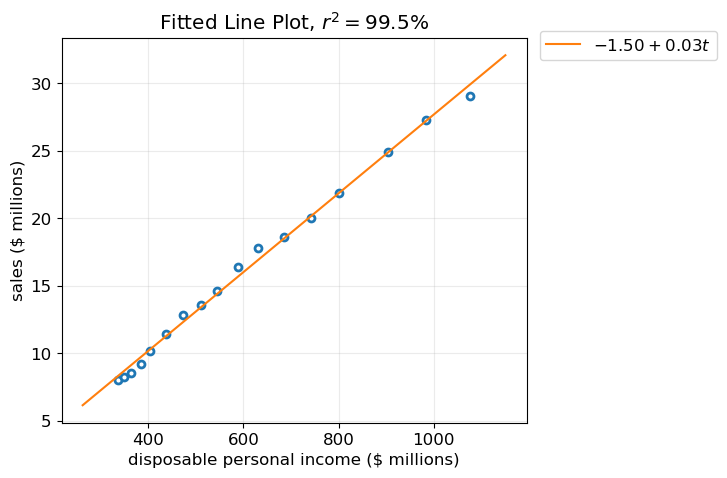

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(df_fit["X_1"], df_fit["Y"], 
  marker='o', markersize=5, markerfacecolor='white',
  linestyle='None', markeredgewidth=2) 

regress = out_dict["regress"]
b0 = regress.intercept_
b1 = regress.coef_[0]

data_t_min = df_fit["X_1"].min()
data_t_max = df_fit["X_1"].max()
t_offset = 0.1*(data_t_max - data_t_min)
t_regress = np.linspace(data_t_min - t_offset, data_t_max + t_offset)
regress_label = r"${:.2f} + {:.2f}t$".format(b0, b1) \
  if b1 > 0 else r"${:.2f}{:.2f}t$".format(b0, b1)

ax.plot(t_regress, b0 + b1*t_regress, 
  linestyle='-',
  label=regress_label) 

ax.set_xlabel(r"disposable personal income ($ millions)")
ax.set_ylabel(r"sales (\$ millions)")

rSq = out_dict["R_sq"]
ax.set_title(r"Fitted Line Plot, $r^2={:.1f}$%".format(rSq*100))

ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)

### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [17]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_fit) 
k_predictors = 1
dw_stats = out_dict["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 0.72
  durbin-watson critical values (d_L, d_U): (1.13, 1.38)
  conclusion: null hypotesis rejected

significance_lvl: 0.01
  durbin-watson statistics: 0.72
  durbin-watson critical values (d_L, d_U): (0.87, 1.1)
  conclusion: null hypotesis rejected



## Two predictors (disposable personal income and unemployment rate)

### Regression Analysis

In [27]:
column_name_2 = ["Sales (Y)", "Income", "Rate"]      # new column name
out_dict_2 = get_minitab_out(df_minitab, n_vars=len(column_name_2)-1, 
  new_column=column_name_2, withVIF=False, withCorrMatrix=False)


Regression Analysis: Sales (Y) versus Income, Rate
The regression equation is
Sales (Y) = -0.014 + 0.030 Income - 0.350 Rate


Predictor,Coef,SE Coef,t-score,p-value
Constant,-0.0140,0.2498,-0.06,0.9560
Income,0.0297,0.0002,119.96,0.0000
Rate,-0.3499,0.0466,-7.51,0.0000


s_yxs = 0.2199   R_sq = 99.9%   R-sq(adj) = 99.9%
Analyis of Variance


Source,d.o.f,sumSq,meanSq,F-score,p-value
Regression,2,738.878,369.439,7637.907,0.0000
Residual error,14,0.677,0.048,,
Total,16,739.555,,,


Durbin-Watson Statistics = 1.98


### Fitted Plane Plot

In [28]:
df_regress = df_minitab.copy()
regress = out_dict_2["regress"]

x_min = df_regress['X_1'].min()
x_max = df_regress['X_1'].max()
x_data = np.linspace(0, x_max, 10)

y_min = df_regress['X_2'].min()
y_max = df_regress['X_2'].max()
y_data = np.linspace(0, y_max, 10)

z_data = regress.intercept_ + regress.coef_[0]*x_data.reshape((-1, 1)) \
  + regress.coef_[1]*y_data

In [29]:
z_color = np.zeros_like(z_data)
x_scatter_data = df_regress['X_1'].to_numpy()
y_scatter_data = df_regress['X_2'].to_numpy()
z_scatter_data = df_regress['Y'].to_numpy()

fig = go.Figure(data=[
  go.Surface(z=z_data.T, x=x_data, y=y_data, 
    colorscale="Blues", surfacecolor=z_color,
    showscale=False, opacity=0.7),
  go.Scatter3d(x=x_scatter_data, y=y_scatter_data, z=z_scatter_data, 
    mode="markers", marker_size=4)])

#go.Figure(data=[go.Scatter3d(x=df_regress['X_1'], y=df_regress['X_2'], 
#  z=df_regress['Y'], mode="markers")])

theta = [160, 60, 65]   # (cosine angle (alpha, beta, gamma))
theta = np.deg2rad(theta)
a = 2.5
camera = {
  'center': {'x': 0, 'y': -0.2, 'z': -0.2},
  'eye': {'x': a*np.cos(theta[0]), 'y': a*np.cos(theta[1]), 'z': a*np.cos(theta[2])}}

fig.update_layout(
  title="Fitted regression plane", autosize=True,
  width=500, height=500,
  margin={'l':35, 'r': 30, 'b':15, 't':50,},
  scene={
    "xaxis_title": "Income",
    "yaxis_title": "Rate",
    "zaxis_title": "Sales"},
  scene_camera=camera)


fig.show()



### Compute $r_1(e)$

In [31]:
df_acorr = df_regress.copy()
df_acorr["e_t"] = df_acorr["Y"] - df_acorr["hat_Y"]
df_acorr

,Y,X_1,X_2,hat_Y,e_t
0,8.0,336.1,5.5,8.060394,-0.060394
1,8.2,349.4,5.5,8.456058,-0.256058
2,8.5,362.9,6.7,8.437829,0.062171
3,9.2,383.9,5.5,9.482405,-0.282405
4,10.2,402.8,5.7,9.974690,0.225310
5,11.4,437.0,5.2,11.167046,0.232954
6,12.8,472.2,4.5,12.459126,0.340874
7,13.6,510.4,3.8,13.840452,-0.240452
8,14.6,544.5,3.8,14.854899,-0.254899
9,16.4,588.1,3.6,16.221937,0.178063


In [35]:
num_of_rk = 10
df_acorr_analysis = get_correlogram(df_acorr, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.004893,0.020175,0.000483,-0.514153,0.514153
1,2,-0.288096,-1.187821,1.787734,-0.514165,0.514165
2,3,-0.291833,-1.114296,3.752644,-0.555201,0.555201
3,4,0.083836,0.299012,3.927274,-0.594370,0.594370
4,5,-0.017194,-0.061004,3.935231,-0.597488,0.597488
5,6,0.125663,0.445757,4.398914,-0.597619,0.597619
6,7,0.096055,0.336819,4.696935,-0.604563,0.604563
7,8,-0.126419,-0.440359,5.270499,-0.608584,0.608584
8,9,-0.206814,-0.712324,6.997419,-0.615487,0.615487
9,10,-0.059341,-0.198546,7.159904,-0.633592,0.633592


In [37]:
r_1 = df_acorr_analysis["r_k"][0]
print(f"lag 1 residual autocorrelation: {r_1}")

lag 1 residual autocorrelation: 0.0048932617273560195


### Durbin-Watson Test

The *Durbin-Watson test* can be used to determine whether positive lag 1
autocorrelation is present.

$$
  \begin{gather*}
    \text{If } DW > d_\mathrm{U}, \text{ conclude } H_0: \rho = 0. \\
    \text{If } DW < d_\mathrm{L}, \text{ conclude } H_1: \rho > 0.
  \end{gather*}
$$

If $DW$ lies withing the lower and upper bounds $(d_\mathrm{L} \leq DW \leq d_\mathrm{U})$,
the test is inconclusive.

In [42]:
significance_lvl = [0.05, 0.01]
n_samples = len(df_fit) 
k_predictors = 2
dw_stats = out_dict_2["dw_stats"]

test_statistic_dw(dw_stats, n_samples, k_predictors, significance_lvl)

significance_lvl: 0.05
  durbin-watson statistics: 1.98
  durbin-watson critical values (d_L, d_U): (1.02, 1.54)
  conclusion: null hypothesis accepted

significance_lvl: 0.01
  durbin-watson statistics: 1.98
  durbin-watson critical values (d_L, d_U): (0.77, 1.25)
  conclusion: null hypothesis accepted



There is no evidence of first-order serial correlation.

### Forecasting

A forecast of Noval sales for 2007

In [54]:
X_1_estimate = 1_185   # disposable personal income ($ millions)
X_2_estimate = 7.8     # unemployment rate (%)

data_struc = np.array([1, X_1_estimate, X_2_estimate])
b_arr = np.hstack([regress.intercept_, regress.coef_])

Y_hat = b_arr.dot(data_struc)

# the difference between the result in here
# and in (Hanke, 2014) is because of rounding process
print(f"Y_hat = {Y_hat:.2f}")   

Y_hat = 32.51
